In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np

In [2]:
file_path = '/kaggle/input/flickr8k/captions.txt'
image_urls=[]
captions=[]
with open(file_path, 'r') as file:
    for line in file:
        image_urls.append(line.strip().split(",")[0])
        captions.append(line.strip().split(",")[1])
image_urls.pop(0)
captions.pop(0)
print(len(image_urls),len(captions))

40455 40455


In [3]:
tokenizer = Tokenizer()
def Tokenize(sentence):
    global tokenizer
    tokenizer.fit_on_texts([sentence])
    sequence = tokenizer.texts_to_sequences([sentence])
    sequence_length = 50  
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=sequence_length)
    return padded_sequence

In [4]:
model = VGG16(weights='imagenet')
def encoder(img):
    global model
    img = image.load_img("/kaggle/input/flickr8k/Images/"+img, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    image_features=model.predict(img_array,verbose=0)
    return image_features

553467096/553467096 [==============================] - 3s 0us/step


In [5]:
def decoder(image_features,caption_embeddings):
    global v,Wh,Ws,battn,decoder_state,opt,LSTM_model,output
    with tf.GradientTape() as tape:
        caption_embeddings=tf.convert_to_tensor(caption_embeddings)
        captions_features=LSTM_model(caption_embeddings)
        e_t_i = v * tf.nn.tanh(Wh * image_features+ Ws*decoder_state+  battn)
        attention_distributon=tf.nn.softmax(e_t_i)
        context_vector=attention_distributon*image_features
        combined=captions_features+attention_distributon
        model_output = output(combined)
        loss = tf.keras.losses.mean_squared_error(captions_features, model_output)
    grads = tape.gradient(loss, LSTM_model.trainable_variables+output.trainable_variables+[v,Wh,Ws,battn])
    opt.apply_gradients(zip(grads, LSTM_model.trainable_variables+output.trainable_variables+[v,Wh,Ws,battn]))
    decoder_state=(decoder_state+context_vector)/2
    print(loss)

In [6]:
v = tf.Variable( tf.random.normal(shape=(1,1000)), trainable=True, name='v')
Wh = tf.Variable(tf.random.normal(shape=(1,1000)), trainable=True, name='Wh')
Ws = tf.Variable(tf.random.normal(shape=(1,1000)), trainable=True, name='Ws')
battn = tf.Variable(tf.random.normal(shape=(1,1000)), trainable=True, name='battn')
decoder_state = tf.zeros((1,1000))
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
LSTM_model = tf.keras.Sequential([ Embedding(input_dim=10000 ,output_dim=20, input_length=50),
tf.keras.layers.LSTM(64, input_shape=(1, 50,20)),
tf.keras.layers.Dense(1000)])
output = tf.keras.Sequential([tf.keras.layers.Dense(1000, activation='softmax')])

In [7]:
def train(image_urls,captions):
    for i in range(len(captions)):
        tokens=Tokenize(captions[i])
        image_features=encoder(image_urls[1])
        decoder(image_features,tokens)

In [8]:
train(image_urls[:200],captions[:200])

tf.Tensor([2.8630236e-06], shape=(1,), dtype=float32)
tf.Tensor([4.395596e-05], shape=(1,), dtype=float32)
tf.Tensor([2.1290834e-05], shape=(1,), dtype=float32)
tf.Tensor([2.515066e-05], shape=(1,), dtype=float32)
tf.Tensor([2.3532622e-05], shape=(1,), dtype=float32)
tf.Tensor([1.9377485e-05], shape=(1,), dtype=float32)
tf.Tensor([1.3718549e-05], shape=(1,), dtype=float32)
tf.Tensor([1.4245675e-05], shape=(1,), dtype=float32)
tf.Tensor([1.6971104e-05], shape=(1,), dtype=float32)
tf.Tensor([1.3656068e-05], shape=(1,), dtype=float32)
tf.Tensor([1.5907433e-05], shape=(1,), dtype=float32)
tf.Tensor([1.081671e-05], shape=(1,), dtype=float32)
tf.Tensor([9.51691e-06], shape=(1,), dtype=float32)
tf.Tensor([1.6225868e-05], shape=(1,), dtype=float32)
tf.Tensor([1.24547005e-05], shape=(1,), dtype=float32)
tf.Tensor([9.120909e-06], shape=(1,), dtype=float32)
tf.Tensor([8.066569e-06], shape=(1,), dtype=float32)
tf.Tensor([9.114033e-06], shape=(1,), dtype=float32)
tf.Tensor([8.052284e-06], shape=(1,

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def test(image,length):
    img = mpimg.imread("/kaggle/input/flickr8k/Images/"+image)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    global v,Wh,Ws,battn,opt,LSTM_model,output,tokenizer
    caption_embeddings = np.zeros((1,50))
    decoder_state = tf.zeros((1,1000))
    image_features=encoder(image)
    for i in range(length):
        captions_features=LSTM_model(caption_embeddings)
        e_t_i = v * tf.nn.tanh(Wh * image_features+ Ws*decoder_state+  battn)
        attention_distributon=tf.nn.softmax(e_t_i)
        context_vector=attention_distributon*image_features
        combined=captions_features+attention_distributon
        model_output = output(combined)
        highest_prob_index=np.argmax(model_output)
        caption_embeddings[0][49-i]=highest_prob_index
        tokentoword={tokenizer.word_index[i]:i for i in tokenizer.word_index.keys()}
        print(tokentoword[49-i])
        decoder_state=(decoder_state+context_vector)/2
    print(caption_embeddings)

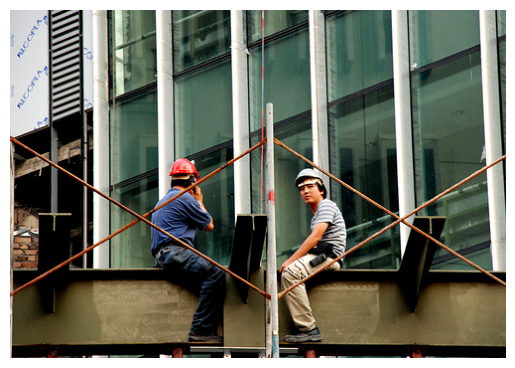

sits
three
person
over
wall
woman
yellow
green
toy
snow
through
his
sitting
little
climbing
blue
beach
red
dogs
playing
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. 604. 604. 604. 604. 604. 604. 604. 604. 604. 604. 604. 604.
  604. 604. 604. 604. 604. 604.  62. 107.]]


In [10]:
test(image_urls[200],20)